## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from sklearn.cluster import KMeans


In [39]:
##################################### CHANGE TRAJECTORY NUMBER HERE #####################################
traj_n = 7
#########################################################################################################

##################################### CHANGE TRAJECTORY MODE HERE #######################################
mode = 'drug'
#########################################################################################################


## Load and Clean Data - V1

In [40]:
# load entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + str(mode) + '/traj_' + str(traj_n) + '/trajectories_na/'
trajectories = os.listdir(path)

# removing NaN columns
nan_cols = []
for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        for i in range(trajectory.shape[1]):
            if np.isnan(trajectory[:, i]).all():
                nan_cols.append(i)

sampling_factor = 20
nan_cols = np.asarray(nan_cols)
a = 0

if nan_cols.size > 0:
    if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
        sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sampling_factor), trajectory.shape[1]-len(nan_cols)) )
        all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]-len(nan_cols)))
else:
    sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sampling_factor), trajectory.shape[1]) )
    all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]))

for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        if nan_cols.size > 0:
            trajectory = np.delete(trajectory, nan_cols, 1)
            
        sampled_idxs = np.round(np.arange(0, trajectory.shape[0], sampling_factor)).astype(int)
        sampled_traj = trajectory[sampled_idxs]
        
        idx = i*sampled_traj.shape[0]
        idx_2 = i*trajectory.shape[0]
                
        sampled_trajectories[idx:idx+sampled_traj.shape[0], 0:sampled_trajectories.shape[1]] = sampled_traj
        all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:all_trajectories.shape[1]] = trajectory
            # convert nan to number when not it is a sparse recurrence (not an entire column)
sampled_trajectories = np.nan_to_num(sampled_trajectories)
all_trajectories = np.nan_to_num(all_trajectories)

print('Data points in sub-sampled trajectory: ', sampled_trajectories.shape)
print('Data points in standard trajectory: ', all_trajectories.shape)

Data points in sub-sampled trajectory:  (167400, 60)
Data points in standard trajectory:  (3348000, 60)


## Load and Clean Data - V2

In [41]:
# load entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + str(mode) + '/traj_' + str(traj_n) + '/trajectories_na/'
trajectories = os.listdir(path)
f_s = 300
# removing NaN columns
nan_cols = []
for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        for i in range(trajectory.shape[1]):
            if np.isnan(trajectory[:, i]).all():
                nan_cols.append(i)

### Helper function

In [42]:
def rolling_mean(x, window, overlapping=True):
    '''
    input:
        x      - input sequence
        window - rolling window
        
    returns:
        y      - moving averaged sequence
    '''
        
    ## assuming that there are more observations than variables:
    if np.max(x.shape)> x.shape[0]:
        x=x.transpose()
        
    if overlapping:
        y = np.zeros((x.shape))
        for i in range(0, x.shape[0] - window):
            y[i, :] = np.mean(x[i:i+window, :], axis=0)

        y[x.shape[0]-window:x.shape[0]-1, :] = x[x.shape[0]-window:x.shape[0]-1, :]
        
    else:
        y = np.zeros((int(x.shape[0]/window), x.shape[1]))
        windows = np.arange(0, x.shape[0] - window, window)
        for i, t in enumerate(windows):
            y[i, :] = np.mean(x[t:t+window, :], axis=0)
    
    return y

In [43]:
nan_cols = np.asarray(nan_cols)
a = 0
sub_sampling = 50
if nan_cols.size > 0:
    if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
        sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
else:
    sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

for i, time_bin in enumerate(trajectories):
    if time_bin != 'behavs':
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        if nan_cols.size > 0:
            trajectory = np.delete(trajectory, nan_cols, 1)
        
        window = sub_sampling
        mov_av_traj = rolling_mean(trajectory, window, overlapping=False)
        idx_2 = i*mov_av_traj.shape[0]
        sampled_trajectories[idx_2:idx_2+mov_av_traj.shape[0], 0:sampled_trajectories.shape[1]] = mov_av_traj
        
# convert nan to number when not it is a sparse recurrence (not an entire column)
sampled_trajectories = np.nan_to_num(sampled_trajectories)
print('Data points in standard trajectory: ', sampled_trajectories.shape)

Data points in standard trajectory:  (66960, 60)


## Dimensionality Reduction: PCA

0.9088722466313366


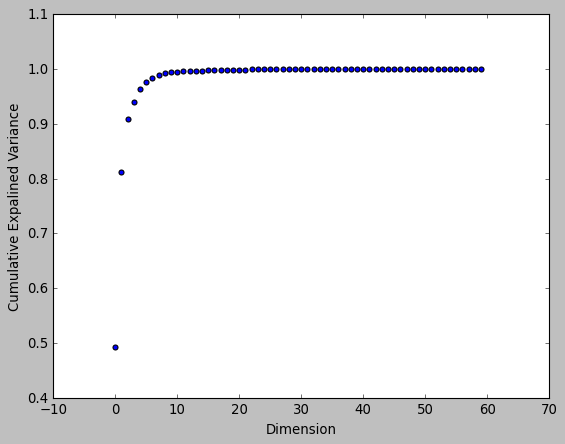

In [44]:
# inspecting inter-dimensional variance with PCA
pca = PCA()
pca.fit(sampled_trajectories)

explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.scatter(np.arange(sampled_trajectories.shape[1]), explained_var_plot)
print(sum(pca.explained_variance_ratio_[0:3]))
plt.ylabel('Cumulative Expalined Variance')
plt.xlabel('Dimension')
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/control/'
name_out = mode + '_explained_var_' + 'traj_' + str(traj_n)
plt.savefig(path_out +  name_out  + ".png")
plt.show()

# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(sampled_trajectories)

## mPE analysis

### Helper functions

In [45]:
def get_mPE_matrix(reduced_traj, bins_number, traj_number, orders=[3], random=False):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    
    for a, order in enumerate(orders):
        
        for i in range(bins_number):
            idx = 0
            
            for j in range(0, traj_length*traj_number, traj_length):
                
                if random:
                    idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                    traj = reduced_traj[idx_1: idx_1 + traj_length]
                else:
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                    
                if traj.shape[0]>0:
                    [HH, _]=mPE_(traj, order)
                    mPE_vector[i, idx, a] = HH
                    
                idx +=1
                
    return mPE_vector

In [46]:
def probability_v2(sequence, centroids):
    '''
    input: 
        - 1D sequence of rv observations
        - centroids (based on k-means clustering)
    return: 
        - probability vector
    '''
    sequence = np.asarray(sequence)
    
    if len(sequence.shape) > 1 and (sequence.shape[0] > sequence.shape[1]):
        sequence = np.transpose(sequence)
        
    if centroids.shape[0] > centroids.shape[1]:
        centroids = centroids.transpose()
    
    n_unique = centroids.shape[1]
    prob_vector = np.zeros((1, n_unique))

    for elem in sequence:
        elem_vector = elem*np.ones((n_unique, ))
        diff = np.absolute(elem_vector - centroids)
        idx = np.where(diff[0]==np.min(diff))[0]
        prob_vector[:, idx] += 1
        
    prob_vector = prob_vector/(sequence.shape[0])
            
    return prob_vector[0]

### Control analysis

In [47]:
# Take random trajectories and check that they have approximately the same mPE
unit_length = 1500
minutes = 60
sub_fs = int(300/60)
bin_length = sub_fs*60*minutes
bins_number = 2
traj_number = int(reduced_traj.shape[0]/2/unit_length)
orders = [3]
random = True

print(reduced_traj.shape[0], bins_number, traj_number)
mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders, random)

66960 2 22


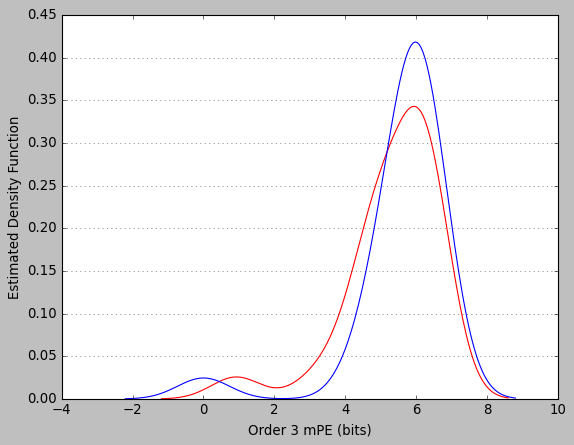

In [48]:
# plotting mpE of the first bin 
order_n = 0
fig = plt.figure()
c = ['r', 'b']
# plotting mPE continuous distribution as a function of time 

ax = sns.kdeplot(mPE_vector[0, :, order_n], color=c[0])
ax = sns.kdeplot(mPE_vector[1,:, order_n], color=c[1])

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Order 3 mPE (bits)')
plt.ylabel('Estimated Density Function')
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/control/'
name_out = mode + '_control_' + 'traj_' + str(traj_n)
plt.savefig(path_out +  name_out  + ".png")

In [49]:
## Retrieve maxiumum number of elements based on a raw decimal discretization
truncation_decimal = 4
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[bin_, traj, order] > max_:
                max_ = mPE_vector[bin_, traj, order]
            elif mPE_vector[bin_, traj, order] < min_:
                min_ = mPE_vector[bin_, traj, order]

min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

## Get probability vectors
prob1 = probability(mPE_vector[0, :, 0], truncation_decimal, max_size)
prob2 = probability(mPE_vector[1, :, 0], truncation_decimal, max_size)

## Evaluation    
significance_lev = 0.01
js_distance = distance.jensenshannon(prob1, prob2)
[_, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])
if p_value >= significance_lev:
    print("same distribution")
else:
    print("different distribution")

print('p-value: ', p_value)
print('j-s: ', js_distance)

same distribution
p-value:  0.21836842129025597
j-s:  [0.]


### Entropy analysis

In [50]:
# Entropy Calculation:
# - Divide entire trajetcory in 'bins_number' bins
# - Divide each bin for 'traj_number' trajectories
# - Calculate mPE for each of these trajectories and compute the distribution

unit_length = 1000
sub_fs = int(300/60)
bins_number = 2
traj_number = int(reduced_traj.shape[0]/2/unit_length)
orders = [3]

print(reduced_traj.shape[0], bins_number, traj_number)
mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders)

66960 2 33


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
  
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend

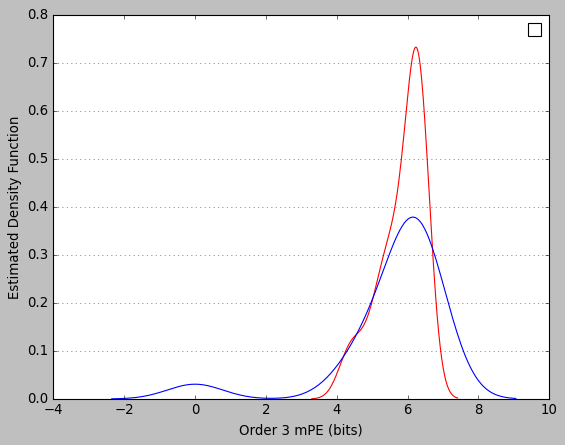

In [51]:
order_n = 0
fig = plt.figure()
c = ['r', 'b']
# plotting mPE continuous distribution as a function of time 
for bin_n in range(bins_number):
    ax = sns.kdeplot(mPE_vector[bin_n, :, order_n], color=c[bin_n])
        
plt.legend('first_half', 'second_half')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Order 3 mPE (bits)')
plt.ylabel('Estimated Density Function')

path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/result/'
name_out = mode + '_result_' + 'traj_' + str(traj_n)
plt.savefig(path_out +  name_out  + ".png")

## Results Evaluation

In [52]:
## Retrieve maxiumum number of elements based on a raw decimal discretization
truncation_decimal = 3
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[bin_, traj, order] > max_:
                max_ = mPE_vector[bin_, traj, order]
            elif mPE_vector[bin_, traj, order] < min_:
                min_ = mPE_vector[bin_, traj, order]

min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))
print(mPE_vector)
## Get probability vectors
prob1 = probability(mPE_vector[0, :, 0], truncation_decimal, max_size)
prob2 = probability(mPE_vector[1, :, 0], truncation_decimal, max_size)
## Evaluation    
significance_lev = 0.01
js_distance = distance.jensenshannon(prob1, prob2)
[stat, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])
if p_value >= significance_lev:
    print("same distribution")
else:
    print("different distribution")

print(p_value)
print(js_distance[0])

[[[4.58335005e+00]
  [5.12249392e+00]
  [6.19212907e+00]
  [6.03937889e+00]
  [5.84369969e+00]
  [5.91363818e+00]
  [6.30590396e+00]
  [4.42497723e+00]
  [5.70377203e+00]
  [6.37035543e+00]
  [6.42957802e+00]
  [6.32868810e+00]
  [6.06265273e+00]
  [5.98649108e+00]
  [6.18293666e+00]
  [6.47709223e+00]
  [6.35528627e+00]
  [5.50033732e+00]
  [6.40230259e+00]
  [6.28275310e+00]
  [6.24920195e+00]
  [5.53538935e+00]
  [4.23801626e+00]
  [5.33712231e+00]
  [4.90054622e+00]
  [5.62391856e+00]
  [6.30582584e+00]
  [6.24280746e+00]
  [6.38835782e+00]
  [6.36245308e+00]
  [5.20475060e+00]
  [5.32517327e+00]
  [6.27127305e+00]]

 [[6.43789886e+00]
  [6.35485669e+00]
  [6.43700411e+00]
  [6.20133046e+00]
  [6.21212307e+00]
  [6.06072793e+00]
  [5.85162455e+00]
  [6.33151174e+00]
  [6.64879613e+00]
  [6.50125030e+00]
  [6.49483778e+00]
  [6.34981313e+00]
  [4.68006806e+00]
  [4.68952326e+00]
  [4.82065376e+00]
  [5.56942981e+00]
  [6.34541353e+00]
  [6.27867356e+00]
  [6.18712350e+00]
  [4.25703